In [109]:
from math import floor


import numpy as np
import matplotlib.pyplot as plt


class Model:

    start_year, start_month, end_year, end_month = 0, 0, 0, 0
    dict_parameters = {}
    dict_money = {}

    current_users = 0
    premium_users = 0
    current_income = 0

    def __calculate_standard_distribution(self, params):
        mean = params['mean']
        standard_deviation = params['sDev']
        return np.random.normal(mean, standard_deviation)

    def __calculate_users_marketing(self, budget):
        cpc = self.__calculate_standard_distribution(self.dict_parameters['marketing']['cpc'])
        cvr = self.__calculate_standard_distribution(self.dict_parameters['marketing']['cvr'])
        users_marketing = budget / cpc * cvr
        return users_marketing

    def __calculate_initial_users(self):
        initial_marketing_budget = self.dict_money['initialCostMarketing']
        inital_users = floor(self.__calculate_users_marketing(initial_marketing_budget))
        return inital_users

    def __init__(self, dict_parameters, dict_dates, dict_money):
        self.start_year = int(dict_dates['startYear'])
        self.start_month = int(dict_dates['startMonth'])
        self.end_year = int(dict_dates['endYear'])
        self.end_month = int(dict_dates['endMonth'])

        self.dict_parameters = dict_parameters
        self.dict_money = dict_money

        self.current_users = self.__calculate_initial_users()

    def __del__(self):
        pass

    def __calculate_new_users(self):
        users_marketing = self.__calculate_users_marketing(self.dict_money['ongoingCostMarketing'])
        referral_rate = self.__calculate_standard_distribution(self.dict_parameters['marketing']['referralRate'])
        users_word_mouth = self.current_users * referral_rate
        marketing_efficiency = self.__calculate_standard_distribution(self.dict_parameters['marketing']['marketingEfficiency'])
        new_users = (users_marketing + users_word_mouth) * marketing_efficiency
        return new_users

    def __recalculate_users(self, new_users):
        attrition_rate = self.__calculate_standard_distribution(self.dict_parameters['attritionRate'])
        self.current_users = floor(self.current_users * (1 - attrition_rate) + new_users)

    def __recalculate_premium_users(self):
        self.premium_users = self.__calculate_standard_distribution(self.dict_parameters['premiumAccountPercentage'])

    def __sessions_count_month(self):
        avg_sessions = self.__calculate_standard_distribution(self.dict_parameters['avgSessionsUser'])
        sessions_count = (1 - self.premium_users) * self.current_users * avg_sessions
        return sessions_count

    def __revenue_premium_account(self):
        revenue_premium_account = self.current_users * self.premium_users * self.dict_money['premiumPrice']
        return revenue_premium_account

    def __adds_revenue(self):
        sessions_count = self.__sessions_count_month()
        cpm = self.__calculate_standard_distribution(self.dict_parameters['adds']['cpm'])
        avg_session_min = self.__calculate_standard_distribution(self.dict_parameters['adds']['avgSessionMin'])
        add_impressions_min = self.__calculate_standard_distribution(self.dict_parameters['adds']['impressionsMin'])
        fill_rate = self.dict_parameters['adds']['fillRate']
        revenue = sessions_count * cpm / 1000 * avg_session_min * add_impressions_min * fill_rate
        return revenue

    def __costs_this_month(self):
        maintenance_cost = self.dict_money['ongoingCostMaintenance']
        costs_this_month = maintenance_cost + self.dict_money['ongoingCostMarketing']
        return costs_this_month

    def __revenue_this_month(self, revenue_adds, revenue_premium, costs):
        total_revenue = revenue_adds + revenue_premium - costs
        return total_revenue

    def __simulate_month(self, first_run):
        if first_run:
            new_users = 0
        else:
            new_users = self.__calculate_new_users()
            self.__recalculate_users(new_users)
        self.__recalculate_premium_users()
        revenue_adds = self.__adds_revenue()
        revenue_premium = self.__revenue_premium_account()
        costs = self.__costs_this_month()

        total_revenue = self.__revenue_this_month(revenue_adds, revenue_premium, costs)
        self.current_income = total_revenue
        return round(revenue_adds + revenue_premium), round(costs)

    def simulate(self):
        list_income = [0]
        initial_costs = self.dict_money['initialCostMarketing'] + self.dict_money['initialCostDevelopment']
        list_costs = [initial_costs]
        list_users = [0]

        first_run = True
        for y in range(self.start_year, self.end_year + 1):
            first_month = self.start_month if y == self.start_year else 1
            for m in range(first_month, 13):
                r, c = self.__simulate_month(first_run)
                first_run = False
                append_costs = list_costs[len(list_costs) - 1] + c
                append_income = list_income[len(list_income) - 1] + r
                list_costs.append(append_costs)
                list_income.append(append_income)
                list_users.append(self.current_users)
                if m == self.end_month and y == self.end_year:
                    break
        return list_income, list_costs, list_users

# multiple similations

def one_app_launch(start_y, start_m, end_y, end_m): 
    dict_temp_dates = {
        'startYear': start_y,
        'startMonth': start_m,
        'endYear': end_y,
        'endMonth': end_m
    }
    my_model = Model(dict_params_test, dict_temp_dates, dict_money_test)
    i, c, u = my_model.simulate()
    return i, c, u

def run_multiple_simulations(simulation_count, release_interval_months, dict_dates):
    simulations = []
    
    year_start = dict_dates_test['startYear']
    month_start = dict_dates_test['startMonth']
    year_end = dict_dates_test['endYear']
    month_end = dict_dates_test['endMonth']
    
    current_year = year_start
    current_month = month_start
    for sim in range(simulation_count):
        i, c , u = one_app_launch(current_year, current_month, year_end, month_end)
        simulations.append((i, c, u))
        current_month = current_month + release_interval_months
        if current_month > 12:
            x = floor(current_month / 12)
            current_month = current_month - 12 * x
            current_year = current_year + x
    return simulations

def combine_simulations(sims):
    stuffed_list = []
    experiment_lenght = len(sims[0][0])
    
    for s in sims:
        si, sc, su = s
        length_difference = experiment_lenght - len(s[0])
        list_temp = [0 for x in range(length_difference)]
        stuffed_list.append((list_temp + si, list_temp + sc, list_temp + su))

    list_combined_sims = []
    combined_income = []
    combined_cost = []
    combined_users = []
    sum_i, sum_c, sum_u = 0, 0, 0

    for step in range(experiment_lenght):
        sum_i, sum_c, sum_u = 0, 0, 0
        for sim_id in range(len(stuffed_list)):
            sum_i = sum_i + stuffed_list[sim_id][0][step]
            sum_c = sum_c + stuffed_list[sim_id][1][step]
            sum_u = sum_u + stuffed_list[sim_id][2][step]
        combined_income.append(sum_i)
        combined_cost.append(sum_c)
        combined_users.append(sum_u)
    list_combined_sims = [combined_income, combined_cost, combined_users]
    return list_combined_sims

In [7]:
#single simulation

dict_params_single = {
    'adds': {
        'cpm': {
            'mean': 3.2,
            'sDev': 0.1
        },
        'avgSessionMin': {
            'mean': 6.6,
            'sDev': 0.5
        },
        'impressionsMin': {
            'mean': 2,
            'sDev': 0.06
        },
        'fillRate': 0.8
    },
    'marketing': {
        'marketingEfficiency': {
            'mean': 1,
            'sDev': 0.1
        },
        'cpc': {
            'mean': 1.47,
            'sDev': 0.1
        },
        'cvr': {
            'mean': 0.12,
            'sDev': 0.01
        },
        'referralRate': {
            'mean': 0.15,
            'sDev': 0.02
        }
    },
    'premiumAccountPercentage': {
        'mean': 0.08,
        'sDev': 0.01
    },
    'avgSessionsUser': {
        'mean': 60,
        'sDev': 2
    },
    'attritionRate': {
        'mean': 0.3,
        'sDev': 0.02
    }

}
dict_dates_single = {
    'startYear': 2019,
    'startMonth': 6,
    'endYear': 2022,
    'endMonth': 6
}
dict_money_single = {
    'premiumPrice': 10,
    'initialCostMarketing': 5000,
    'initialCostDevelopment': 2000,
    'ongoingCostMarketing': 2000,
    'ongoingCostMaintenance': 200
}


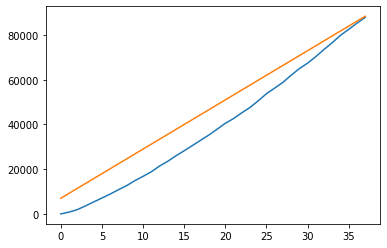

In [10]:
# single simulation

my_model = Model(dict_params_single, dict_dates_single, dict_money_single)
i, c, u = my_model.simulate()

# plt.plot(u)
plt.plot(i)
plt.plot(c)
plt.show()


In [25]:
#neutral

In [26]:
#pesymitic

In [27]:
#optymistic

In [42]:
# test

dict_params_test = {
    'adds': {
        'cpm': {
            'mean': 3.2,
            'sDev': 0.1
        },
        'avgSessionMin': {
            'mean': 6.6,
            'sDev': 0.5
        },
        'impressionsMin': {
            'mean': 2,
            'sDev': 0.06
        },
        'fillRate': 0.8
    },
    'marketing': {
        'marketingEfficiency': {
            'mean': 1,
            'sDev': 0.1
        },
        'cpc': {
            'mean': 1.47,
            'sDev': 0.1
        },
        'cvr': {
            'mean': 0.12,
            'sDev': 0.01
        },
        'referralRate': {
            'mean': 0.15,
            'sDev': 0.02
        }
    },
    'premiumAccountPercentage': {
        'mean': 0.08,
        'sDev': 0.01
    },
    'avgSessionsUser': {
        'mean': 60,
        'sDev': 2
    },
    'attritionRate': {
        'mean': 0.3,
        'sDev': 0.02
    }

}
dict_dates_test = {
    'startYear': 2019,
    'startMonth': 6,
    'endYear': 2020,
    'endMonth': 6
}
dict_money_test = {
    'premiumPrice': 10,
    'initialCostMarketing': 5000,
    'initialCostDevelopment': 2000,
    'ongoingCostMarketing': 2000,
    'ongoingCostMaintenance': 200
}


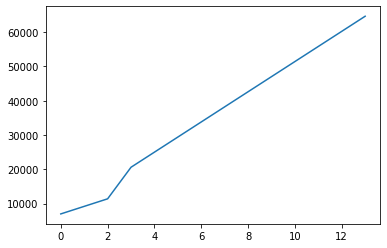

In [110]:


sims = run_multiple_simulations(2, 3, dict_dates_test)
i, c, u = combine_simulations(sims)

plt.plot(c)


[]